# BC 3

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

April 2022

## Initial Setup

### Imports


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections

warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import is_color_like

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# pip install nltk
import nltk

## Uncomment these on first run
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


### Variables

In [3]:
COLORS = ['#e06666', '#e88b81', '#f0ad9a', '#f8ceb2', '#ffeeca', '#c6cfbf', '#8fb0ae', '#58919d', '#20718b']

CAT_COLORS = ['#20718b', '#7DB082', '#FAEC73', '#ECA052', '#e06666']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#e06666', '#e68d8d', '#ebb1b1', '#efd3d3', '#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = 'imgs/'
DATA_PATH = 'data/'


In [4]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


In [5]:
## Function to plot histograms of numeric features for specified dfframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables", bins=10):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0], bins=bins)
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

### Styles

In [6]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

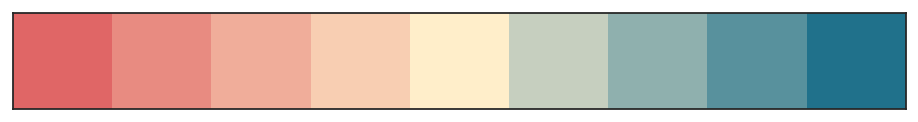

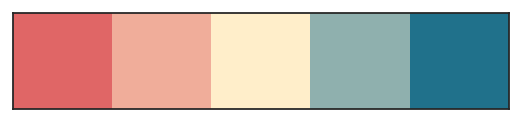

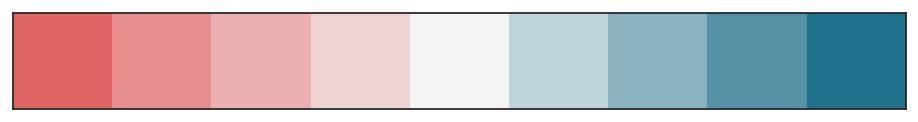

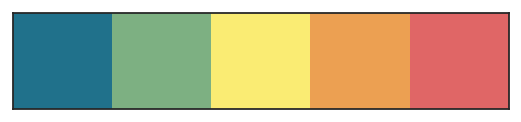

In [7]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load df

In [8]:
df = pd.read_csv("../../source/retail.csv")
df_orig = df.copy()

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## Data Understanding

In [12]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [13]:
## Add IsCancelled column

df['IsCancelled'] = False
df.loc[df['InvoiceNo'].str.startswith("C"),['IsCancelled']] = True


In [14]:
print(round(df['CustomerID'].isna().sum()/df.shape[0]*100,2), "% of CustomerID column is NULL.")


24.93 % of CustomerID column is NULL.


In [15]:
## Fill NaN customer id with 0 
df['CustomerID'] = df['CustomerID'].fillna(0)

In [16]:
df['CustomerID'] = df['CustomerID'].astype(int)

In [17]:
df.loc[df['CustomerID'].isna(),:].groupby(['InvoiceNo']).size()

Series([], dtype: int64)

In [18]:
inv_cust = df.loc[:,['InvoiceNo','CustomerID', 'IsCancelled','Quantity']]
inv_cust['CustomerID'] = inv_cust['CustomerID'].fillna('NA')
inv_cust['combi']=inv_cust['InvoiceNo'].astype(str)+"__"+inv_cust['CustomerID'].astype(str)


In [19]:
print("Number of unique InvoiceNo:")
len(inv_cust['InvoiceNo'].unique())


Number of unique InvoiceNo:


25900

In [20]:
print("Number of unique combinations of InvoiceNo + CustomerID:")
len(inv_cust['combi'].unique())


Number of unique combinations of InvoiceNo + CustomerID:


25900

In [21]:
print("Number of unique CustomerID:")
len(inv_cust['CustomerID'].unique())

Number of unique CustomerID:


4373

Drop NULL CustomerID? Or treat as one customer?


In [22]:
print("Number of unique InvoiceNo for NULL CustomerID")
len(inv_cust.loc[inv_cust['CustomerID']==0,'InvoiceNo'].unique())

Number of unique InvoiceNo for NULL CustomerID


3710

In [23]:
print('Percent of Invoices with NULL CustomerID')
round(100*len(inv_cust.loc[inv_cust['CustomerID']==0,'InvoiceNo'].unique())/len(inv_cust['combi'].unique()),2)


Percent of Invoices with NULL CustomerID


14.32

In [24]:
print('Percent of Cancelled Invoices with NULL CustomerID')
round(100*len(inv_cust.loc[(inv_cust['CustomerID']==0)&(inv_cust['IsCancelled']==True),'InvoiceNo'].unique())\
          /len(inv_cust['combi'].unique()),2)


Percent of Cancelled Invoices with NULL CustomerID


0.7

In [25]:
print('Number of Cancelled Invoices')
print(inv_cust.loc[inv_cust['IsCancelled']==True,'InvoiceNo'].nunique())


Number of Cancelled Invoices
3836


### Remove invoice lines with non-product lines

In [26]:
#unique_stockcode = pd.DataFrame(df.groupby(['StockCode','Description']).size()).reset_index().loc[:,['StockCode','Description']]#.reset_index()
#unique_stockcode.to_csv('unique_stockcodes.csv')

In [27]:
filtered_stockcodes = pd.read_csv('../remove_stock.csv')
filtered_stockcodes = filtered_stockcodes.fillna(0)
filtered_stockcodes['Remove'] = filtered_stockcodes['Remove'].astype(int)
filtered_stockcodes['StockCodeDescription'] = filtered_stockcodes['StockCode']+'__'+filtered_stockcodes['Description']

remove_stockcodes = filtered_stockcodes.loc[:,['StockCodeDescription','Remove']]
df['StockCodeDescription'] = df['StockCode']+'__'+df['Description']
df = df.merge(right=remove_stockcodes, on="StockCodeDescription", how='left')


In [28]:
df_removed_sd = df.loc[df['Remove']==1]
print('Rows removed with non-product descriptions:')
print(len(df_removed_sd))

df = df.loc[df['Remove']==0].drop(columns=['Remove', 'StockCodeDescription']).reset_index(drop=True)

Rows removed with non-product descriptions:
3641


In [29]:
df_orig['Description'].nunique()

4223

### Distribution of customer purchases

In [30]:
df['Value'] = df['Quantity']*df['UnitPrice']

In [31]:
#val_hist = val_hist.loc[val_hist['Quantity']<=1000,:].loc[size_hist['Quantity']>0,:]
#val_hist.describe()

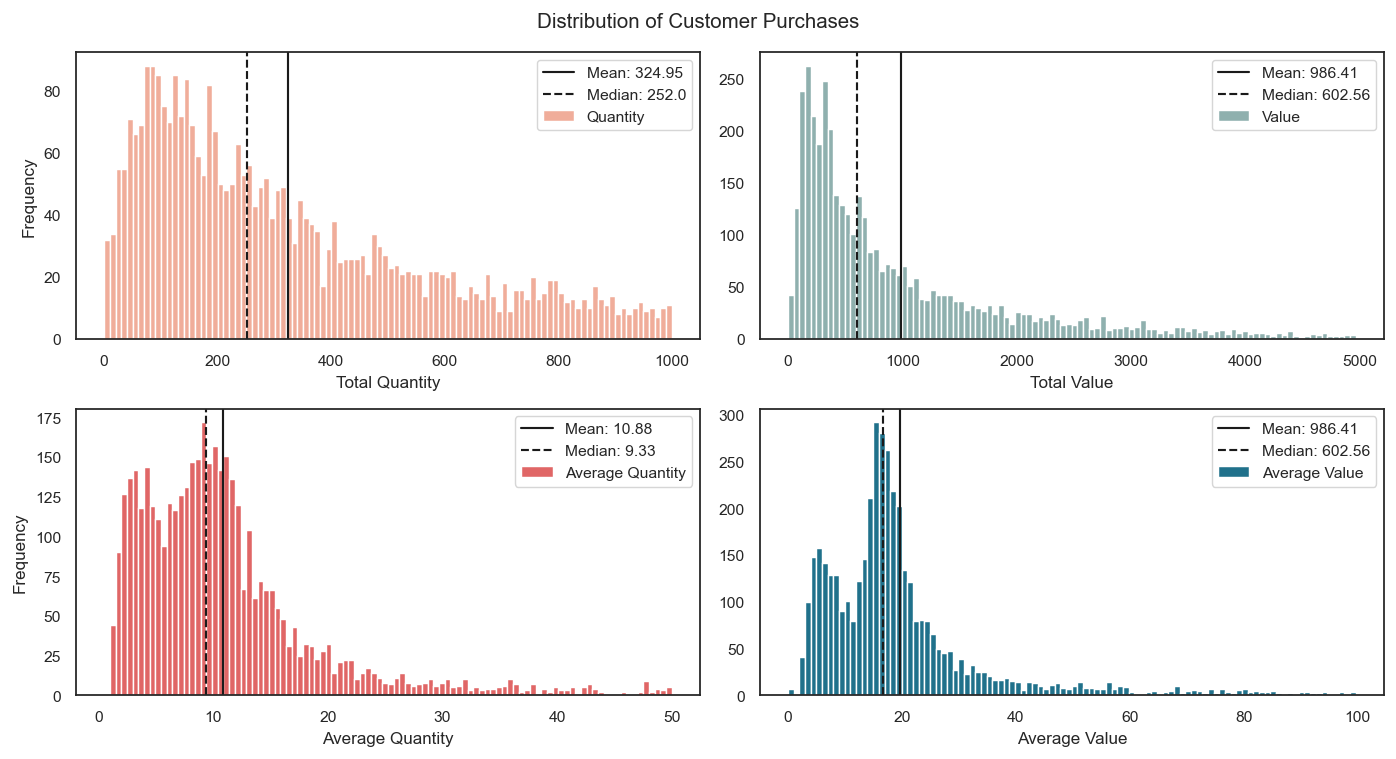

In [32]:
fig, ax = plt.subplots(2,2, figsize=(11,6))

size_hist = pd.DataFrame(df.groupby(['CustomerID']).sum()['Quantity'],columns=['Quantity'])
size_hist = size_hist.loc[size_hist['Quantity']<=1000,:].loc[size_hist['Quantity']>0,:]

ax[0][0].hist(size_hist, bins=100, label='Quantity', color=COLORS[2])

size_h_mean_label = "Mean: " + str(round(size_hist['Quantity'].mean(),2))
size_h_median_label = "Median: " + str(round(size_hist['Quantity'].median(),2))

ax[0][0].axvline(size_hist['Quantity'].mean(), color='k', label=size_h_mean_label)
ax[0][0].axvline(size_hist['Quantity'].median(), color='k', linestyle='--', label=size_h_median_label)
ax[0][0].set_xlabel('Total Quantity')
ax[0][0].set_ylabel('Frequency')
ax[0][0].legend()

val_hist = pd.DataFrame(df.loc[df['CustomerID']!=0].groupby(['CustomerID']).sum()['Value'],columns=['Value'])
val_hist = val_hist.loc[(val_hist['Value']<=5000)&(val_hist['Value']>0),:] #.loc[size_hist['Value']>0,:]


ax[0][1].hist(val_hist, bins=100, color=COLORS[-3], label='Value')

v_h_mean_label = "Mean: " + str(round(val_hist['Value'].mean(),2))
v_h_median_label = "Median: " + str(round(val_hist['Value'].median(),2))

ax[0][1].axvline(val_hist['Value'].mean(), color='k', label=v_h_mean_label)
ax[0][1].axvline(val_hist['Value'].median(), color='k', linestyle='--', label=v_h_median_label)
ax[0][1].set_xlabel('Total Value')
#ax[0][1].set_ylabel('Frequency')
ax[0][1].legend()



######## Averages

size_ave = pd.DataFrame(df.groupby(['CustomerID']).mean()['Quantity'],columns=['Quantity'])
size_ave = size_ave.loc[size_ave['Quantity']<=50,:].loc[size_ave['Quantity']>0,:]

ax[1][0].hist(size_ave, bins=100, label='Average Quantity', color=COLORS[0])

size_h_mean_label2 = "Mean: " + str(round(size_ave['Quantity'].mean(),2))
size_h_median_label2 = "Median: " + str(round(size_ave['Quantity'].median(),2))

ax[1][0].axvline(size_ave['Quantity'].mean(), color='k', label=size_h_mean_label2)
ax[1][0].axvline(size_ave['Quantity'].median(), color='k', linestyle='--', label=size_h_median_label2)
ax[1][0].set_xlabel('Average Quantity')
ax[1][0].set_ylabel('Frequency')
ax[1][0].legend()



val_hist_ave = pd.DataFrame(df.loc[df['CustomerID']!=0].groupby(['CustomerID']).mean()['Value'],columns=['Value'])
val_hist_ave = val_hist_ave.loc[(val_hist_ave['Value']<=100)&(val_hist_ave['Value']>0),:] #.loc[size_hist['Value']>0,:]


ax[1][1].hist(val_hist_ave, bins=100, color=COLORS[-1], label='Average Value')

v_h_mean_label2 = "Mean: " + str(round(val_hist['Value'].mean(),2))
v_h_median_label2 = "Median: " + str(round(val_hist['Value'].median(),2))

ax[1][1].axvline(val_hist_ave['Value'].mean(), color='k', label=v_h_mean_label2)
ax[1][1].axvline(val_hist_ave['Value'].median(), color='k', linestyle='--', label=v_h_median_label2)
ax[1][1].set_xlabel('Average Value')
#ax[1][1].set_ylabel('Frequency')
ax[1][1].legend()



fig.suptitle('Distribution of Customer Purchases')

plt.tight_layout()
plt.show()

save_fig("Customer Purchases", fig)


In [33]:
invoice_hist = pd.DataFrame(df.loc[df['CustomerID']!=0].groupby(['CustomerID']).mean()['Value'],columns=['Value'])
invoice_hist = invoice_hist.loc[(invoice_hist['Value']<=100)&(invoice_hist['Value']>0),:] #.loc[size_hist['Value']>0,:]




In [34]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,Value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,False,22.00


In [35]:
datetime.today()

datetime.datetime(2022, 4, 14, 16, 16, 58, 156983)

In [36]:
df_invoices = df.loc[df['CustomerID']!=0,:].groupby("InvoiceNo").agg(
    val_tot=pd.NamedAgg(column="Value", aggfunc="sum"),
    val_ave=pd.NamedAgg(column="Value", aggfunc="mean"),
    qty_tot=pd.NamedAgg(column="Quantity", aggfunc="sum"),
    qty_ave=pd.NamedAgg(column="Quantity", aggfunc="mean"),
    qty_count=pd.NamedAgg(column="Quantity", aggfunc="count"),
    last_purch=pd.NamedAgg(column="InvoiceDate", aggfunc="max"),
    CustomerID=pd.NamedAgg(column="CustomerID", aggfunc="max"),
    )

In [37]:
df_invoices.head(3)

,val_tot,val_ave,qty_tot,qty_ave,qty_count,last_purch,CustomerID
InvoiceNo,,,,,,,
536365,139.12,19.874286,40,5.714286,7,2010-12-01 08:26:00,17850
536366,22.20,11.100000,12,6.000000,2,2010-12-01 08:28:00,17850
536367,278.73,23.227500,83,6.916667,12,2010-12-01 08:34:00,13047


In [38]:
print(df_invoices.columns.tolist())

['val_tot', 'val_ave', 'qty_tot', 'qty_ave', 'qty_count', 'last_purch', 'CustomerID']


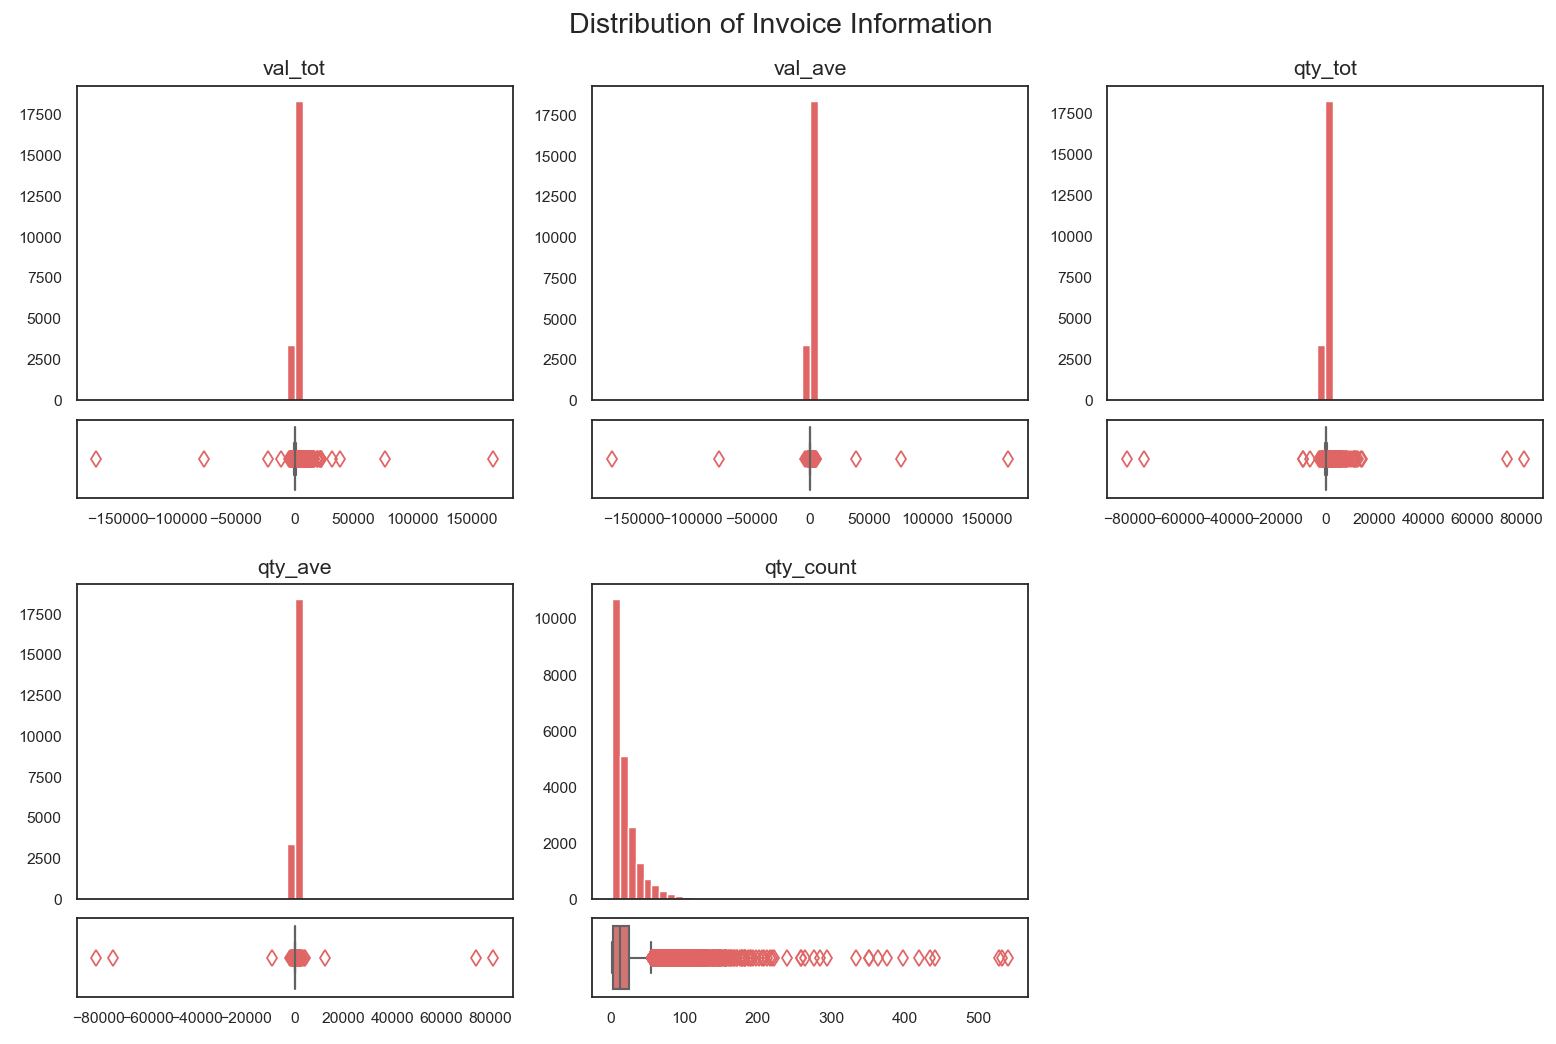

In [39]:
inv_cols = ['val_tot', 'val_ave', 'qty_tot', 'qty_ave', 'qty_count']
plot_histograms_boxplots(df_invoices, inv_cols, rows=2, title ="Distribution of Invoice Information", bins=50)


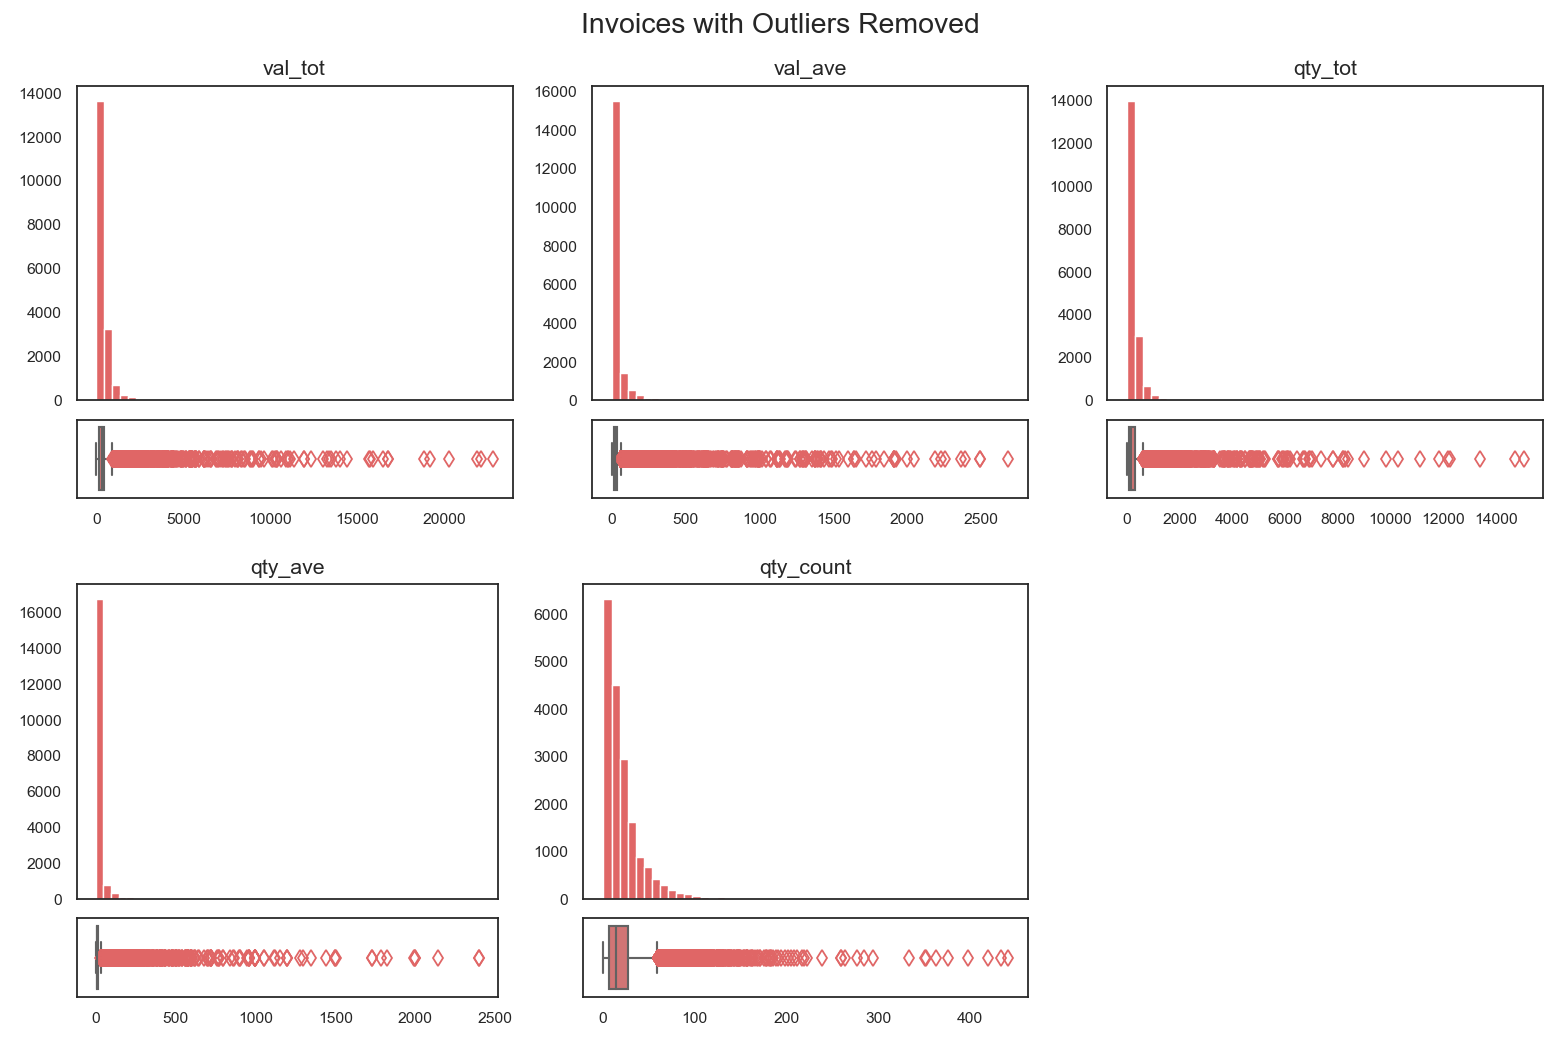

In [40]:
df_inv_ = df_invoices.loc[df_invoices['qty_tot']>0]
df_inv_ = df_inv_.loc[df_inv_['val_ave']<3000]
df_inv_ = df_inv_.loc[df_inv_['val_tot']<25000]
df_inv_ = df_inv_.loc[df_inv_['qty_ave']<3000]
df_inv_ = df_inv_.loc[df_inv_['qty_count']<500]

plot_histograms_boxplots(df_inv_, inv_cols, rows=2, title ="Invoices with Outliers Removed", bins=50)


### RFM

In [41]:
rfm = df_invoices.loc[df_invoices['CustomerID']!=0,:].groupby("CustomerID").agg(
    val_tot=pd.NamedAgg(column="val_tot", aggfunc="sum"),
    val_ave=pd.NamedAgg(column="val_ave", aggfunc="mean"),
    qty_tot=pd.NamedAgg(column="qty_tot", aggfunc="sum"),
    qty_ave=pd.NamedAgg(column="qty_ave", aggfunc="mean"),
    invoice_count=pd.NamedAgg(column="qty_count", aggfunc="count"),
    last_purch=pd.NamedAgg(column="last_purch", aggfunc="max"),
    )

rfm['recency'] = rfm['last_purch'].apply( lambda x: (datetime.today() - x).days)
rfm['frequency'] = rfm['invoice_count']
rfm['monetary'] = rfm['val_tot']

#rfm

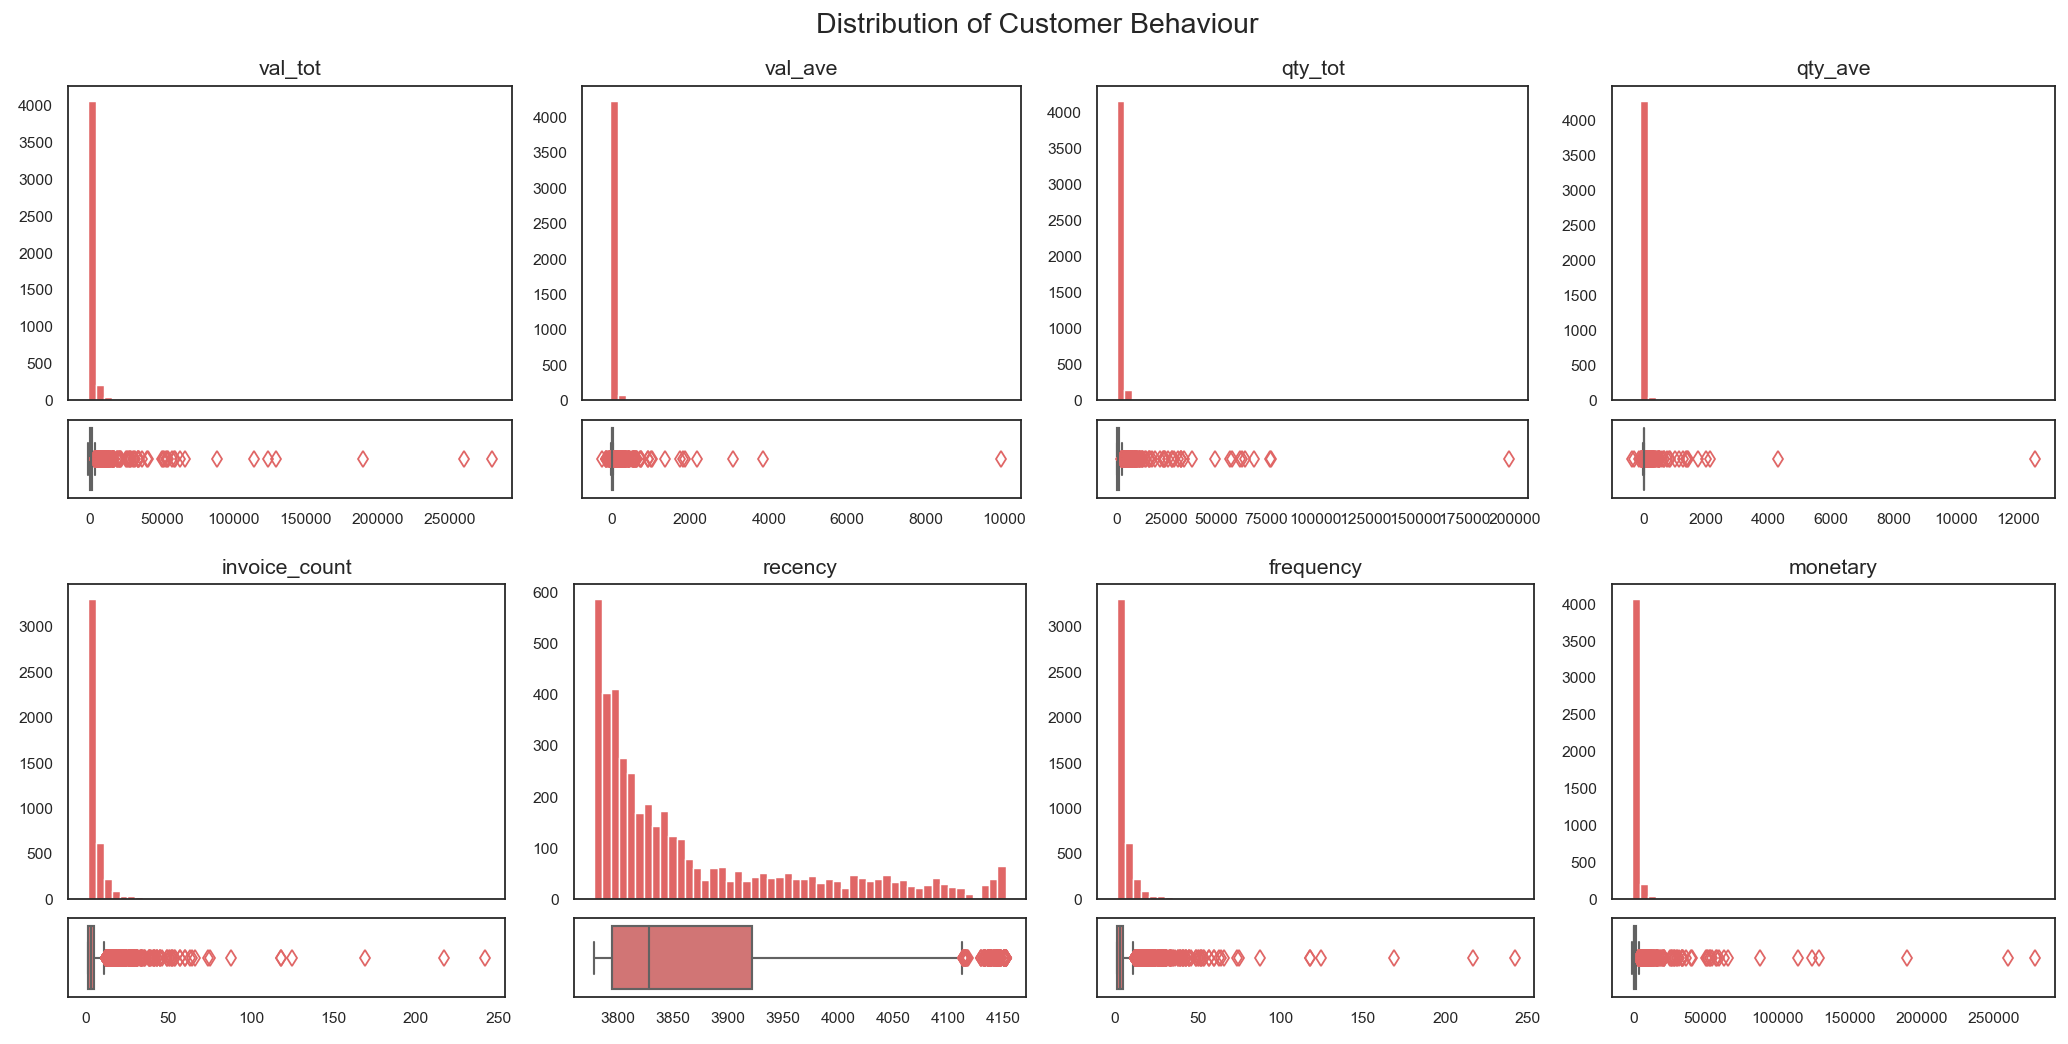

In [42]:
rfm_cols = ['val_tot', 'val_ave', 'qty_tot', 'qty_ave', 'invoice_count', 'recency', 'frequency', 'monetary']
plot_histograms_boxplots(rfm, rfm_cols, rows=2, title ="Distribution of Customer Behaviour", bins=50)


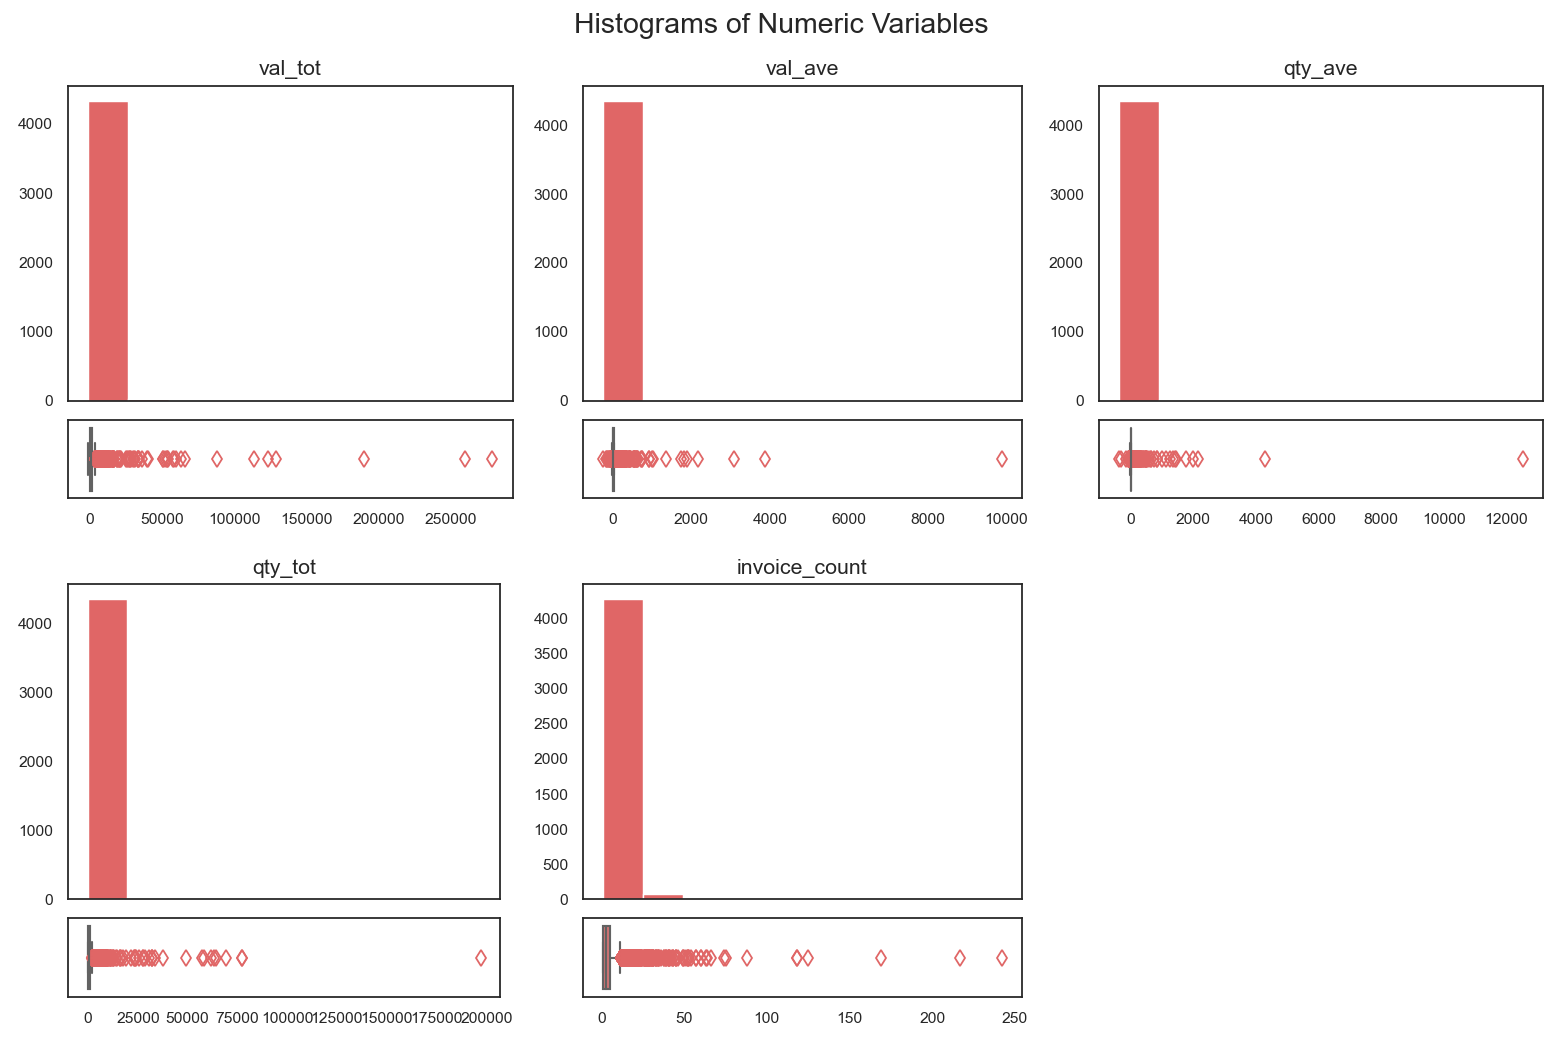

In [43]:
def make_corr_heatmap(df, method, title="Triangle Correlation Heatmap"):
    l = len(df.columns.tolist())
    fig, ax = plt.subplots(figsize=(.75*l, .4*l))
    mask = np.triu(np.ones_like(df.corr(method=method), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=method), mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f' ,cmap=DIV_CMAP)
    heatmap.set_title(title, fontdict={'fontsize':14}, pad=2);
    for t in ax.texts:
        if float(t.get_text())>=0.4:
            t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
        else:
            t.set_text("")
    #save_fig(title, fig)
    plt.show()
    



rfm.columns
rfm_cluster = rfm.loc[:,['val_tot', 'val_ave', 'qty_ave', 'qty_tot', 'invoice_count']]
plot_histograms_boxplots(rfm_cluster, rfm_cluster.columns.tolist(), rows=2, title ="Histograms of Numeric Variables")



rfm_cluster = rfm_cluster.loc[rfm_cluster['val_tot']<50000]
rfm_cluster = rfm_cluster.loc[rfm_cluster['qty_tot']<100000]
rfm_cluster = rfm_cluster.loc[rfm_cluster['qty_ave']<4000]
rfm_cluster = rfm_cluster.loc[rfm_cluster['val_ave']<3000]
rfm_cluster = rfm_cluster.loc[rfm_cluster['val_ave']>0]



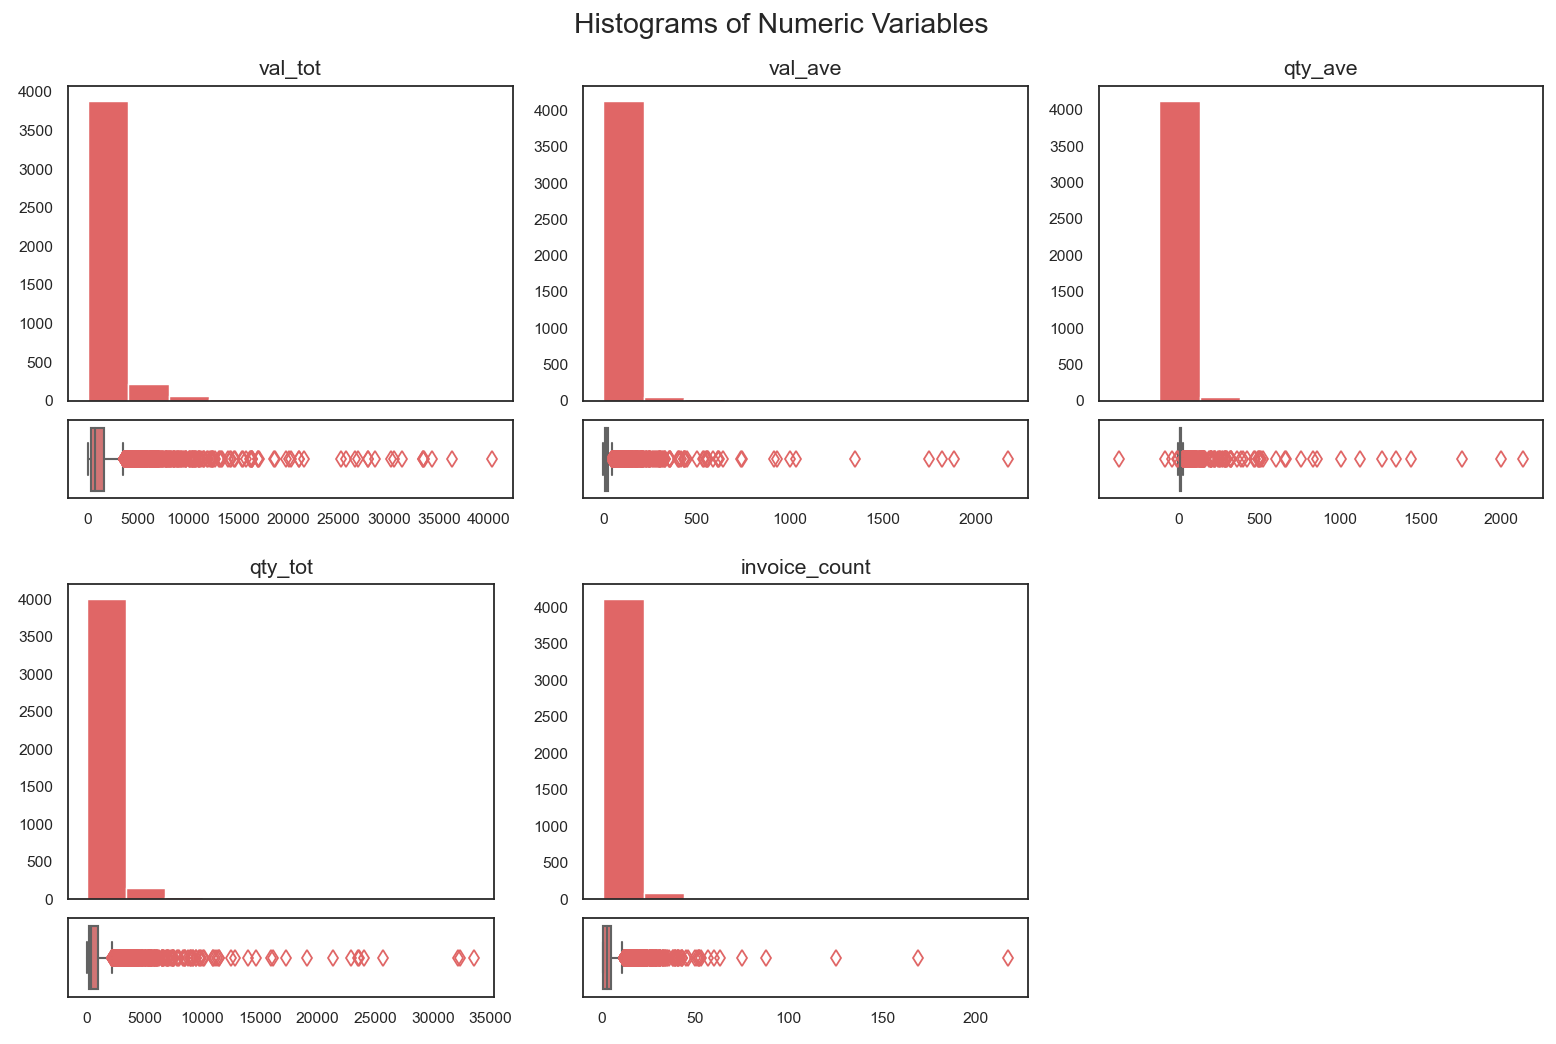

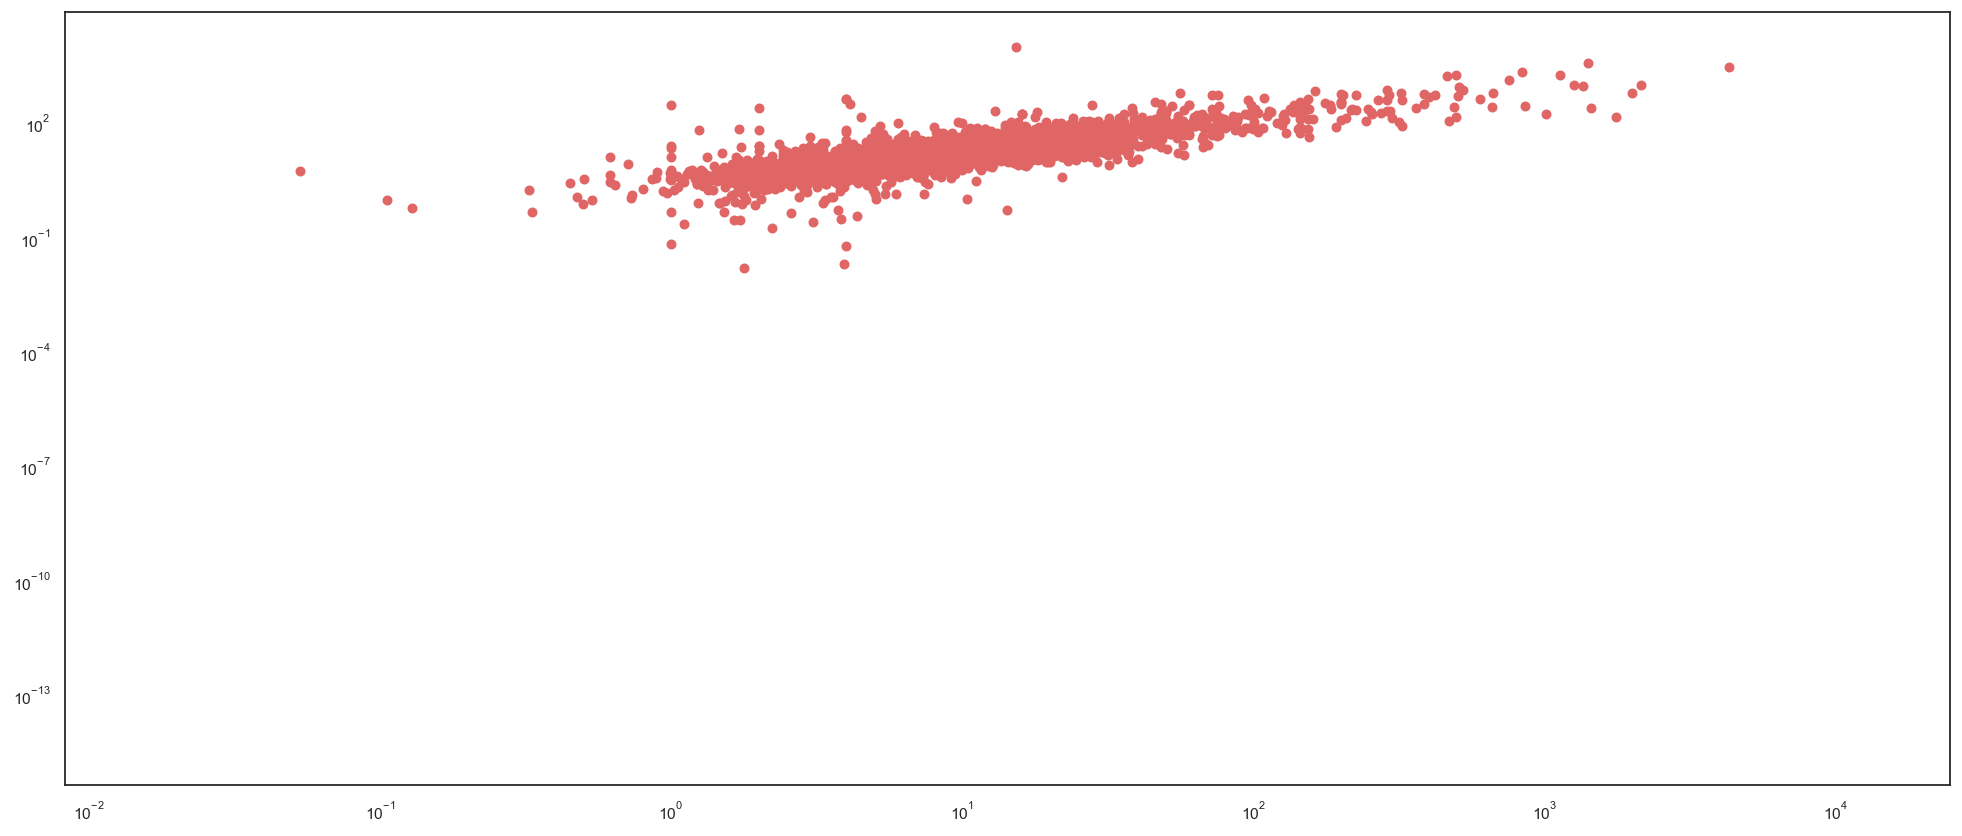

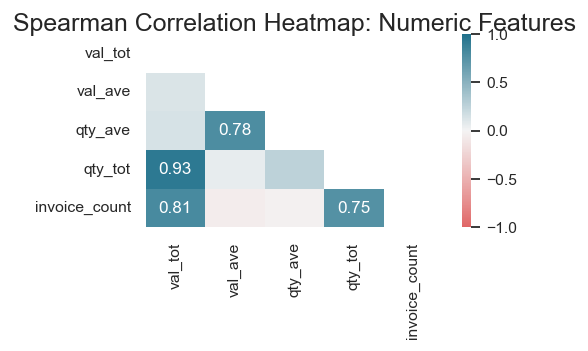

In [44]:
plot_histograms_boxplots(rfm_cluster, rfm_cluster.columns.tolist(), rows=2, title ="Histograms of Numeric Variables")


fig, ax = plt.subplots(figsize=(19,8))

ax.scatter(rfm['qty_ave'], rfm['val_ave'])
ax.set_yscale('log')
ax.set_xscale('log')

plt.show()

make_corr_heatmap(rfm_cluster, 'spearman', title="Spearman Correlation Heatmap: Numeric Features")


## Reduce Sparsity

### Remove stop words

In [45]:
stop = text.ENGLISH_STOP_WORDS

In [46]:
print(pd.Series(' '.join(df['Description']).lower().split()).value_counts()[:100])

set        54575
of         53351
bag        51911
red        42902
heart      38714
           ...  
cup         5048
candles     5046
hearts      5023
jam         4997
knob        4953
Length: 100, dtype: int64


In [47]:
df_descriptions = df.copy()

In [48]:
common_words = pd.DataFrame(pd.Series(' '.join(df['Description']).lower().split()).value_counts()[:100], columns=['common'])

In [49]:
stop2 = ['SET', 'OF', 'OF4', 'IN', 'AND', 'ASSORTED', 'KIT', 
         'WITH', '12', '4', '3' '2', '60CM', '60x40CM', '60', '6',
         'SET/6', 'S/6', '10', 'SET/2', 'SET/20', 'SET/12', 'SET/10',
         'SET/20','SET/3','SET/4','SET/5','SET/9','SET3',
         'S/2','S/12','S/72', 'S/3','S/4',
         'PACK','PACK/12', 'PACK/2'
        ]

stop2 = [ str.lower(i) for i in stop2]

In [50]:
stop3 = [
    "SMALL", "LARGE", "MEDIUM", "JUMBO", 
]

stop3 = [ str.lower(i) for i in stop3]

In [51]:
#df.loc[df['Description'].str.contains('MINI'),'Description'].unique()

In [52]:
df_descriptions['Description'] = df_descriptions['Description'].str.lower()
df_descriptions['Description'] = df_descriptions['Description'].str.strip()
df_descriptions['Description'] = df_descriptions['Description'].str.replace("  ", " ")
df_descriptions['Description'] = df_descriptions['Description'].str.replace("  ", " ")


In [53]:
df_descriptions['NoStop'] = df_descriptions['Description'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (stop)]))
#df_descriptions['NoStop'] = df_descriptions['NoStop'].str.replace('  ', ' ')

df_descriptions['NoStop'] = df_descriptions['NoStop'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (stop2)]))
#df_descriptions['NoStop'] = df_descriptions['NoStop'].str.replace('  ', ' ')

df_descriptions['NoStop'] = df_descriptions['NoStop'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (stop3)]))
#df_descriptions['NoStop'] = df_descriptions['NoStop'].str.replace('  ', ' ')


In [54]:
df_descriptions['NoStop'] = df_descriptions['NoStop'].str.replace('  ', ' ')


In [55]:
print(len(df_descriptions['NoStop'].unique()))


3914


In [56]:
desc_ = df_descriptions['Description'].unique().tolist()
nostop_ = df_descriptions['NoStop'].unique().tolist()

#for i in desc_:
#    if i not in nostop_:
#        print(i)

print(len(desc_), len(nostop_))

4009 3914


In [57]:
## Remove symbols
df_descriptions['NoStop'] = df_descriptions['NoStop'].replace(r'[^A-Za-z0-9 ]+', '', regex=True)

## Remove digits
df_descriptions['NoStop'] = df_descriptions['NoStop'].str.replace(r'\d+','')

df_descriptions['NoStop'] = df_descriptions['NoStop'].apply(lambda x: x.strip())
df_descriptions['NoStop'] = df_descriptions['NoStop'].str.replace('  ',' ')


In [58]:
print(len(df_descriptions['Description'].unique()))
print(len(df_descriptions['NoStop'].unique()))


4009
3846


### Remove single char words


In [59]:

df_descriptions['NoStop'] = df_descriptions['NoStop'].apply(lambda x: ' '.join( [w for w in x.split() if len(w)>1] ) )
df_descriptions['NoStop'] = df_descriptions['NoStop'].apply(lambda x: x.strip())
df_descriptions['NoStop'] = df_descriptions['NoStop'].str.replace('  ',' ')


In [60]:
#df_descriptions.head()

### Try stemming

In [61]:
# Lemmatizer has better results, use that instead

In [62]:
#stemmer = PorterStemmer()
#df_descriptions['stemmed'] = df_descriptions['NoStop'].str.lower()

#def stem_sentences(sentence):
#    tokens = sentence.split()
#    stemmed_tokens = [stemmer.stem(token) for token in tokens]
#    return ' '.join(stemmed_tokens)

#df_descriptions['stemmed'] = df_descriptions['stemmed'].apply(stem_sentences)

#print(len(df_descriptions['stemmed'].unique()))

### Use lemmatizer

In [63]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sentences(sentence):
    tokens = sentence.split()
    Lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(Lemmatized_tokens)


In [64]:
df_descriptions['Lemmatized'] = df_descriptions['NoStop'].str.lower()

In [65]:
df_descriptions['Lemmatized'] = df_descriptions['Lemmatized'].apply(lemmatize_sentences)
df_descriptions['Lemmatized'] = df_descriptions['Lemmatized'].str.replace('  ', ' ')
df_descriptions['Lemmatized'] = df_descriptions['Lemmatized'].str.strip()


In [66]:
df_descriptions.loc[df_descriptions['NoStop'].str.contains('babushka'), ['Description', 'NoStop', 'Lemmatized']]

,Description,NoStop,Lemmatized
5,set 7 babushka nesting boxes,babushka nesting boxes,babushka nesting box
62,set 7 babushka nesting boxes,babushka nesting boxes,babushka nesting box
79,set 7 babushka nesting boxes,babushka nesting boxes,babushka nesting box
291,set 7 babushka nesting boxes,babushka nesting boxes,babushka nesting box
298,babushka lights string of 10,babushka lights string,babushka light string
...,...,...,...
536459,pin cushion babushka blue,pin cushion babushka blue,pin cushion babushka blue
536497,small yellow babushka notebook,yellow babushka notebook,yellow babushka notebook
536498,small purple babushka notebook,purple babushka notebook,purple babushka notebook
536499,small red babushka notebook,red babushka notebook,red babushka notebook


In [67]:
desc_ = df_descriptions['NoStop'].unique().tolist()
lemma_ = df_descriptions['Lemmatized'].unique().tolist()

#for i in desc_:
#    if i not in lemma_:
#        print(i)

#print(len(desc_), len(lemma_))

### Remove colors

In [68]:
color_url = 'https://xkcd.com/color/rgb.txt'
color_names = pd.read_table(color_url).reset_index().iloc[:,0].tolist()
print('cream' in color_names)

True


In [69]:
manual_colors = ['rose', 'cream']

In [70]:
df_rose = df_descriptions.loc[df_descriptions['Lemmatized'].str.contains('rose')].head(5)
#df_rose

In [71]:
def check_color(color):
    if is_color_like(color):
        return True
    elif color in color_names:
        return True
    else : 
        return False

In [72]:
df_descriptions['HasColor'] = df_descriptions['Lemmatized'].apply(lambda x: [i for i in x.split(' ') if check_color(i)])

In [73]:
#df_descriptions.head(5)

In [74]:
def extract_color(sentence):
    tokens = sentence.split(' ')
    res = [check_color(i) for i in tokens]
    res_ = [tokens[i] for i in range(len(tokens)) if res[i]==True]
    if len(res_) > 0 : 
        return res_[0]
    else :
        return False


In [75]:
def remove_color(sentence, color):
    #print(sentence, color)
    if color == False:
        return sentence
    else :
        return sentence.replace(color, "")

In [76]:
#df_rose['HasColor'] = df_rose['Lemmatized'].apply(lambda x: [i for i in x.split(' ') if check_color(i)])
#df_rose['HasColor']

In [77]:
#df_rose['Color'] = df_rose['Lemmatized'].apply(extract_color)
#df_rose

In [78]:

#df_descriptions.loc[df_descriptions['Lemmatized'].str.contains('rose')].head(5)#.loc[:,['Lemmatized','Color']].apply(lambda row: remove_color(row['Lemmatized'],row['Color']) , axis=1)



In [79]:
df_descriptions['Color'] = df_descriptions['Lemmatized'].apply(extract_color)

In [80]:
df_descriptions['NoColor'] = df_descriptions.loc[:,['Lemmatized','Color']].apply(lambda row: remove_color(row['Lemmatized'],row['Color']) , axis=1)
df_descriptions['NoColor'] = df_descriptions['NoColor'].str.strip()
df_descriptions['NoColor'] = df_descriptions['NoColor'].str.replace('  ',' ')


In [81]:
len(df_descriptions['NoColor'].unique())

3368

In [82]:
df_descriptions['Color2'] = df_descriptions['NoColor'].apply(extract_color)
df_descriptions['NoColor'] = df_descriptions.loc[:,['NoColor','Color2']].apply(lambda row: remove_color(row['NoColor'],row['Color2']) , axis=1)
df_descriptions['NoColor'] = df_descriptions['NoColor'].apply(lambda x: x.strip())
df_descriptions['NoColor'] = df_descriptions['NoColor'].str.replace('  ',' ')


In [83]:
len(df_descriptions['NoColor'].unique())
# 3444

3331

In [84]:
len(df_descriptions['InvoiceNo'].unique())

23211

In [85]:
df_descriptions.loc[df_descriptions['NoColor'].str.contains('glass heart trinket pot'), 'NoColor'].unique()

array(['glass heart trinket pot'], dtype=object)

In [86]:
len(df_descriptions['Description'].unique())

4009

### Remove adjectives

In [87]:
def remove_adjectives(sentence):
    
    t_ = nltk.pos_tag(sentence.lower().split(" "))

    return ' '.join([t[0] for t in t_ if t[1] != 'JJ'])


In [88]:
df_descriptions['NoAdjectives'] = df_descriptions['NoColor'].apply(remove_adjectives)

In [89]:
df_descriptions.loc[df_descriptions['Description'].str.contains('rose'), ['Description','NoStop', 'Lemmatized', 'NoColor', 'HasColor', 'Color', 'NoAdjectives']]

,Description,NoStop,Lemmatized,NoColor,HasColor,Color,NoAdjectives
192,rose caravan doorstop,rose caravan doorstop,rose caravan doorstop,caravan doorstop,[rose],rose,caravan doorstop
214,rose cottage keepsake box,rose cottage keepsake box,rose cottage keepsake box,cottage keepsake box,[rose],rose,cottage keepsake box
229,english rose hot water bottle,english rose hot water bottle,english rose hot water bottle,english hot water bottle,[rose],rose,water bottle
328,set of 4 english rose placemats,english rose placemats,english rose placemats,english placemats,[rose],rose,placemats
329,set of 4 english rose coasters,english rose coasters,english rose coaster,english coaster,[rose],rose,coaster
...,...,...,...,...,...,...,...
536313,overnight bag vintage rose paisley,overnight bag vintage rose paisley,overnight bag vintage rose paisley,overnight bag vintage paisley,[rose],rose,bag vintage paisley
536361,roses regency teacup and saucer,roses regency teacup saucer,rose regency teacup saucer,regency teacup saucer,[rose],rose,regency teacup saucer
536386,regency tea plate roses,regency tea plate roses,regency tea plate rose,regency plate,"[tea, rose]",tea,regency plate
536434,set of 4 english rose placemats,english rose placemats,english rose placemats,english placemats,[rose],rose,placemats


In [90]:
orig_ = df_orig['Description'].unique().tolist()

desc_ = df_descriptions['Description'].unique().tolist()
stop_ = df_descriptions['NoStop'].unique().tolist()
lemma_ = df_descriptions['Lemmatized'].unique().tolist()
color_ = df_descriptions['NoColor'].unique().tolist()
adj_ = df_descriptions['NoAdjectives'].unique().tolist()

#for i in desc_:
#    if (i not in stop_) :
#        print(i)

print(len(orig_), len(desc_), len(stop_), len(lemma_), len(color_), len(adj_))
# 4224 4009 3866 3835 3444 3298
# 4224 4009 3866 3835 3357 3186

4224 4009 3818 3807 3331 3158


In [91]:
#df_descriptions.to_csv('../data_cleaned.csv')

In [92]:
#df_descriptions

In [93]:
df_out = df_descriptions.loc[:,['InvoiceNo', 'Quantity', 'UnitPrice', 'Value', 'CustomerID', 'InvoiceDate', 'IsCancelled', 'NoAdjectives']]
df_out = df_out.rename(columns={'NoAdjectives': 'Description'})
#df_out['InvoiceDate'] = df_out['InvoiceDate']
df_out

,InvoiceNo,Quantity,UnitPrice,Value,CustomerID,InvoiceDate,IsCancelled,Description
0,536365,6,2.55,15.30,17850,2010-12-01 08:26:00,False,hanging heart tlight holder
1,536365,6,3.39,20.34,17850,2010-12-01 08:26:00,False,metal lantern
2,536365,8,2.75,22.00,17850,2010-12-01 08:26:00,False,heart coat hanger
3,536365,6,3.39,20.34,17850,2010-12-01 08:26:00,False,knitted union flag water bottle
4,536365,6,3.39,20.34,17850,2010-12-01 08:26:00,False,woolly heart
...,...,...,...,...,...,...,...,...
536809,581587,12,0.85,10.20,12680,2011-12-09 12:50:00,False,spaceboy napkin
536810,581587,6,2.10,12.60,12680,2011-12-09 12:50:00,False,childrens apron dolly
536811,581587,4,4.15,16.60,12680,2011-12-09 12:50:00,False,childrens cutlery dolly
536812,581587,4,4.15,16.60,12680,2011-12-09 12:50:00,False,childrens cutlery circus parade


## Export Data

In [94]:
df_out.to_csv('../data_cleaned.csv', index=False)

## Visualize Sparsity

In [95]:
def make_heatmap(df, title="Heatmap", fs=(50,40)):
    l = len(df.columns.tolist())

    fig, ax = plt.subplots(figsize=fs)
    mask = np.triu(np.ones_like(df, dtype=bool))
    heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=False ,
                          cmap=DIV_H_CMAP, ax=ax, cbar=False,
                          )
    #ax.set_yticklabels([])
    #ax.set_xticklabels([])
    title = str(df.shape[0]) + ' Invoices x ' + str(df.shape[1]) + ' Products'

    ax.set_title(title, fontsize=40)
    save_fig(title, fig)
    plt.show()

In [96]:
heatmap_inv = df_out.loc[df_out['IsCancelled']==False,'InvoiceNo'].unique().tolist()


In [97]:
df_heatmap = df_out.loc[df_out['InvoiceNo'].isin(heatmap_inv)]
df_basket_heatmap = df_heatmap.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')


In [98]:

df_basket_heatmap_t = df_basket_heatmap.T
df_basket_heatmap_t['Sum'] = df_basket_heatmap_t.sum(axis=1)
df_basket_heatmap = df_basket_heatmap_t.sort_values(by='Sum', ascending=False).drop(columns=['Sum']).T

#df_basket_heatmap

In [99]:
df_basket_heatmap['Sum'] = df_basket_heatmap.sum(axis=1)
df_basket_heatmap = df_basket_heatmap.sort_values(by='Sum', ascending=False).drop(columns=['Sum'])
#df_basket_heatmap

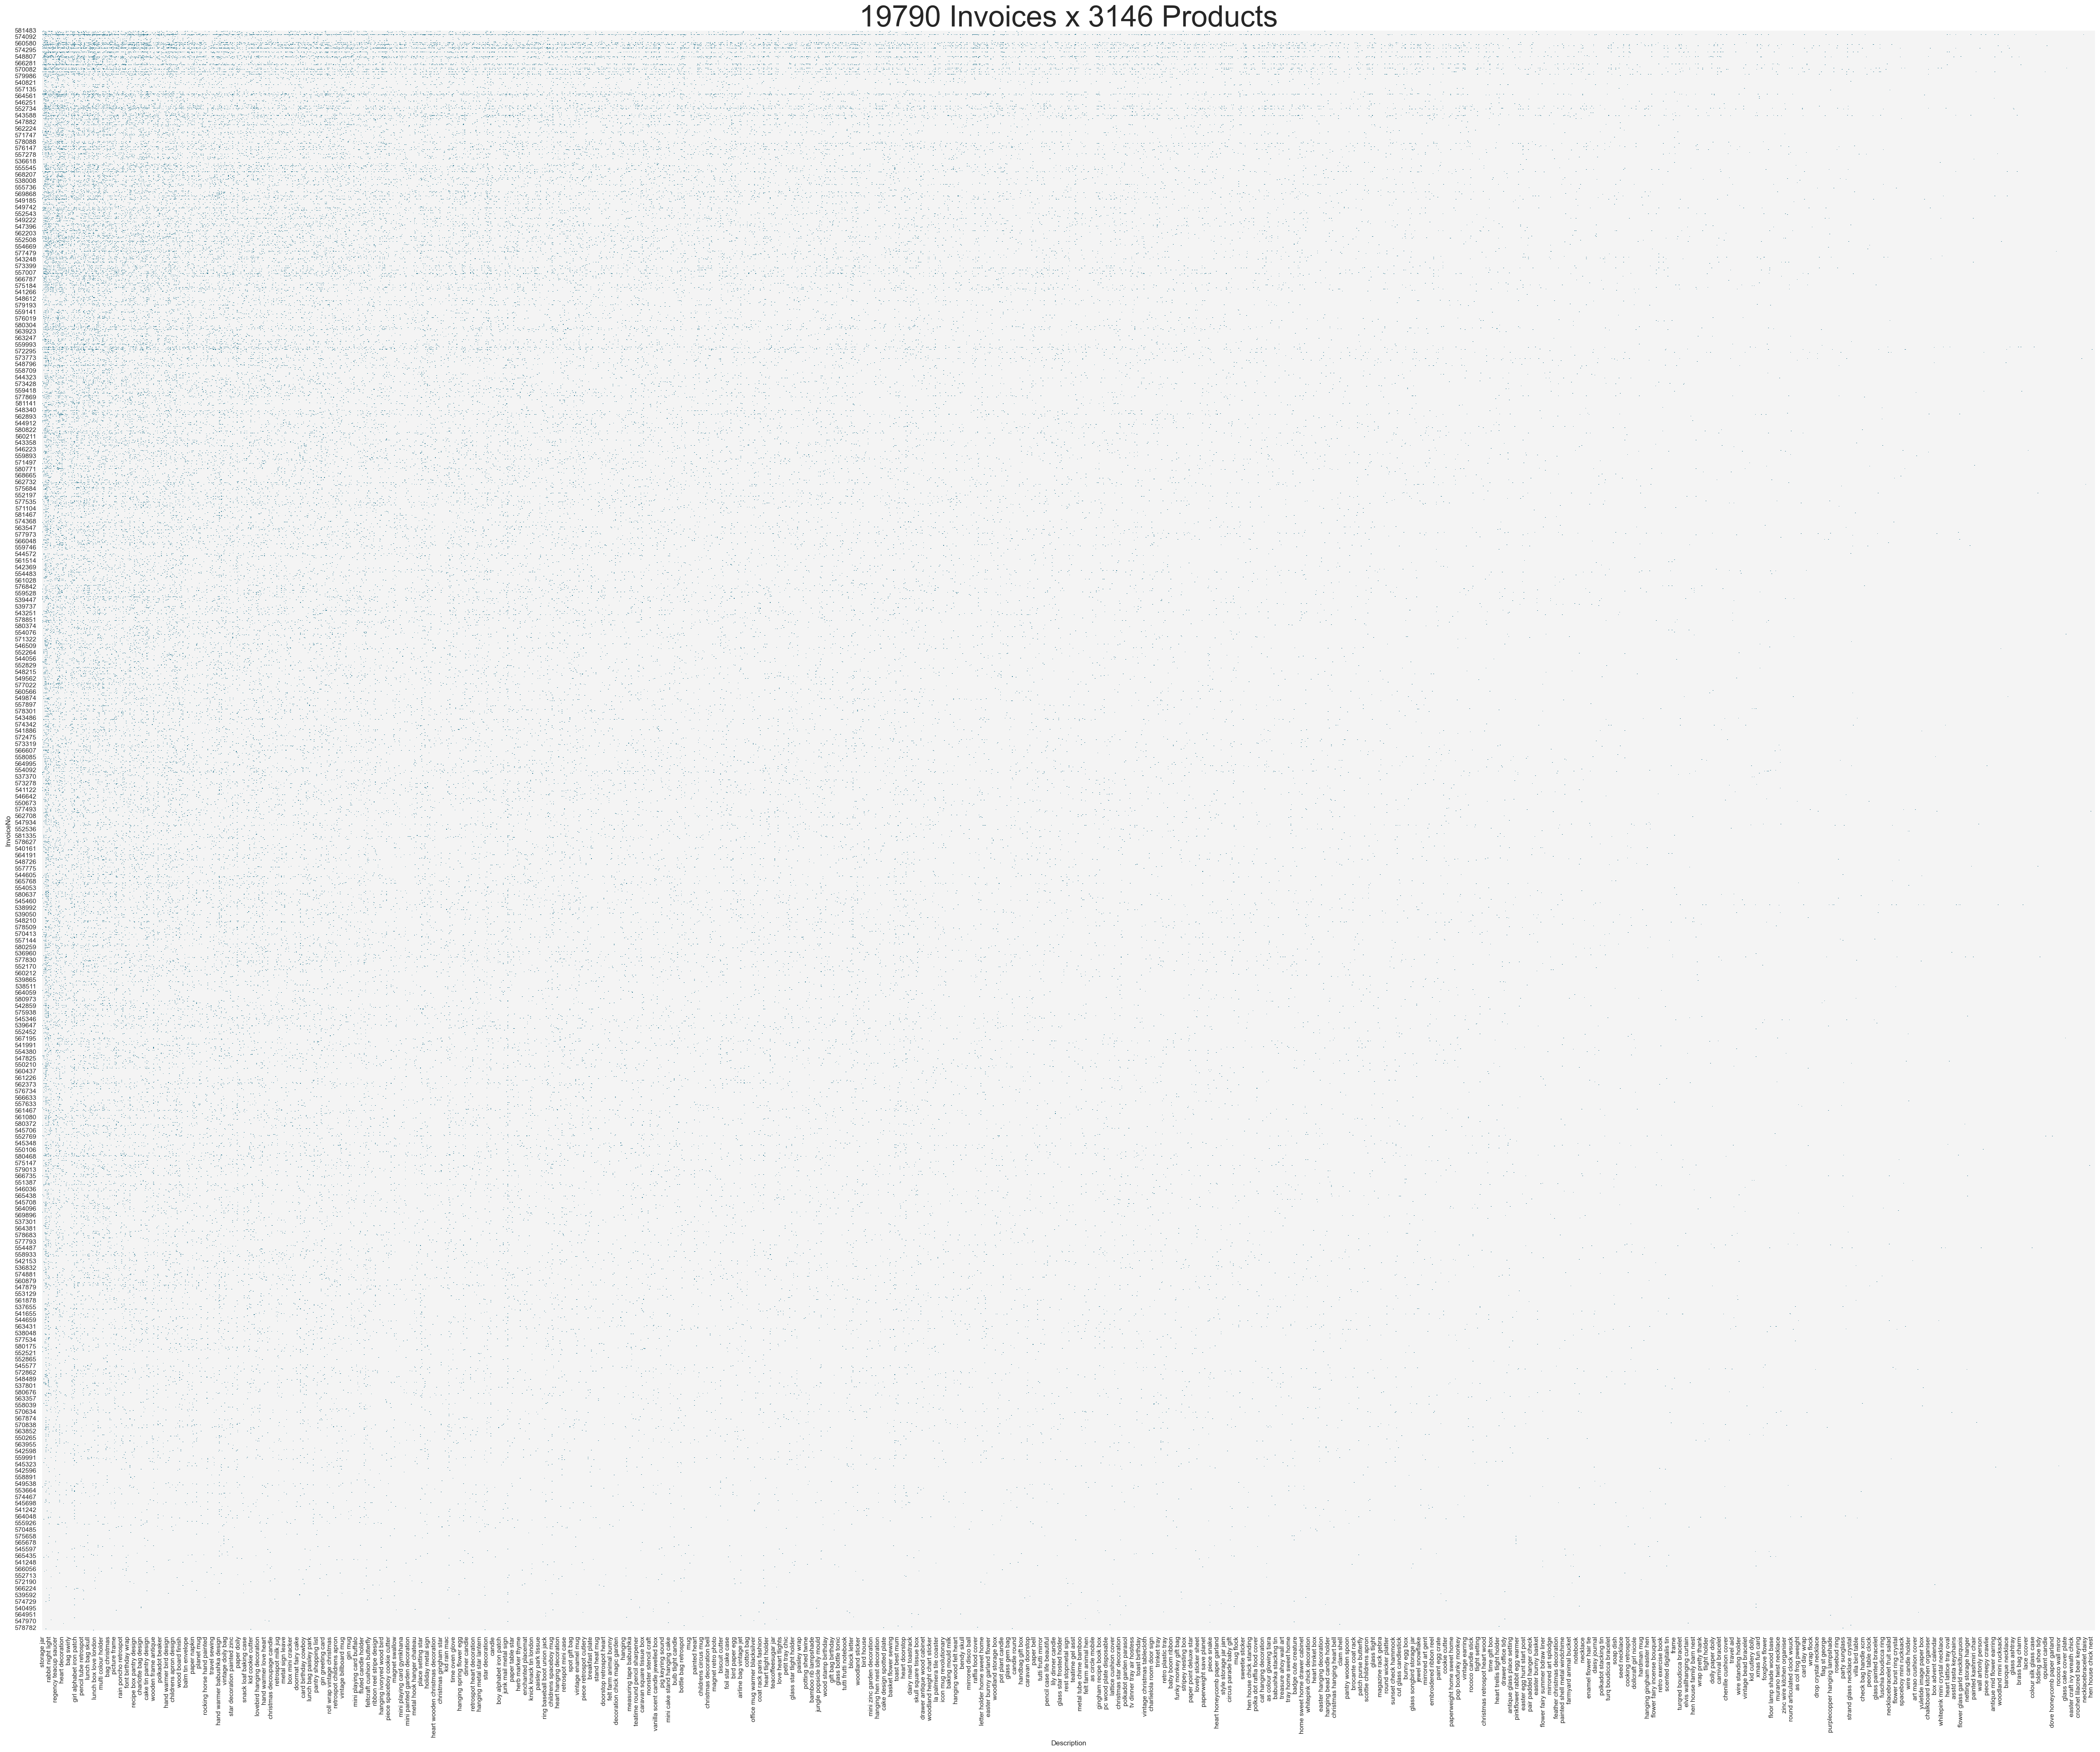

In [100]:
make_heatmap(df_basket_heatmap)


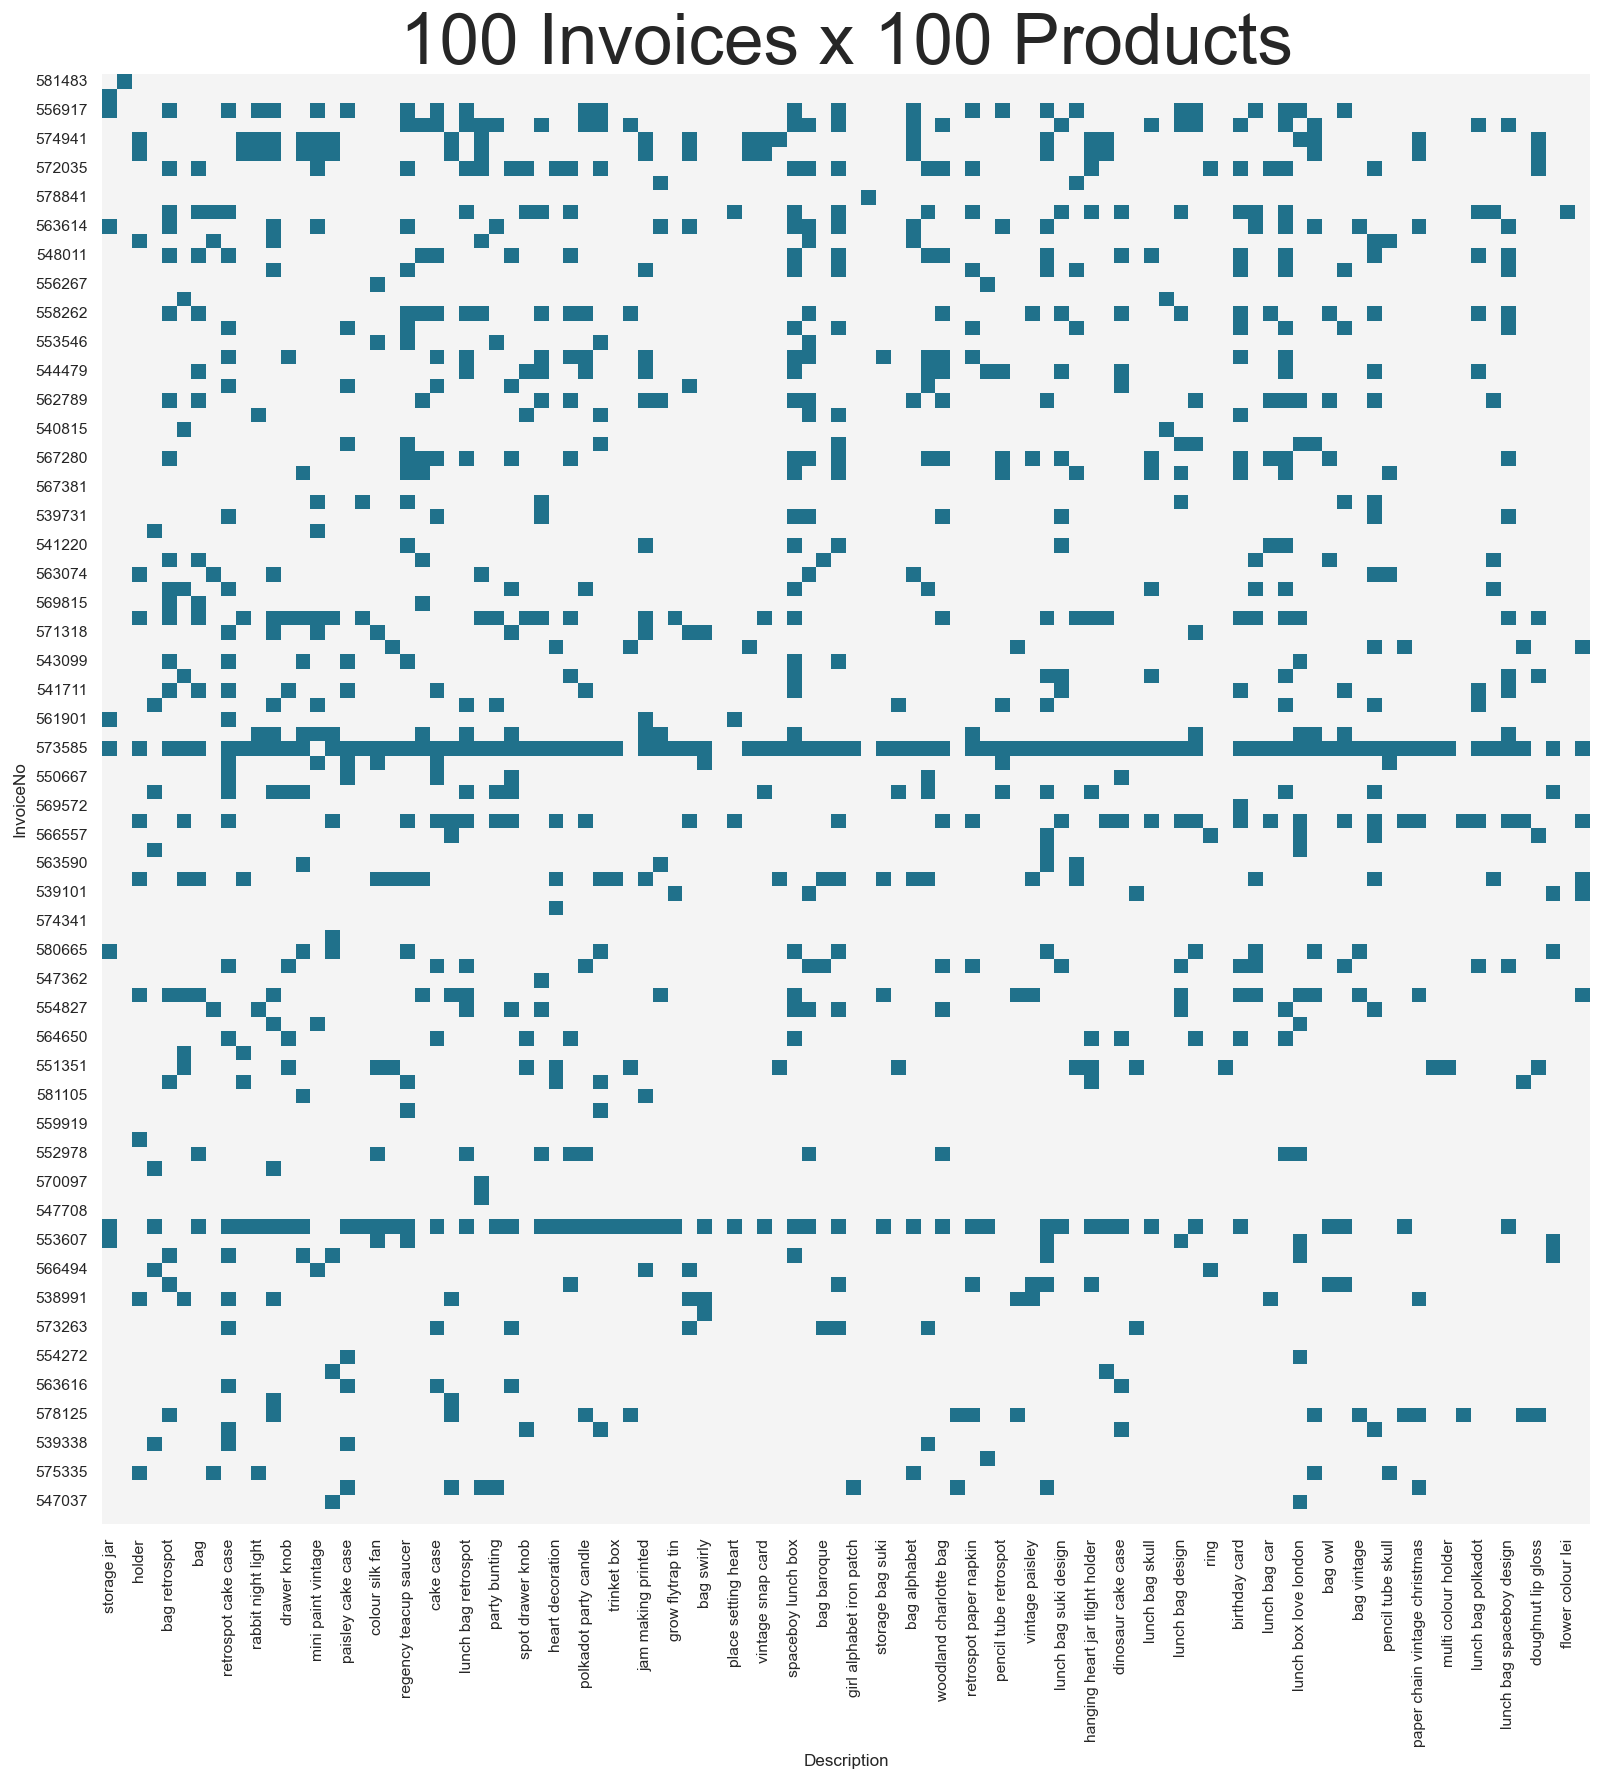

In [101]:
make_heatmap(df_basket_heatmap.iloc[0:100,0:100], fs=(15,15))


## Cluster customers

In [102]:
import umap
import umap.plot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



In [103]:
# Unique items per customer
# Total items per customer
# Total invoices per customer
#df_out.loc[df_out['Quantity']<0]

In [104]:
df_out.loc[df_out['CustomerID']==12346]

,InvoiceNo,Quantity,UnitPrice,Value,CustomerID,InvoiceDate,IsCancelled,Description
61149,541431,74215,1.04,77183.6,12346,2011-01-18 10:01:00,False,storage jar
61154,C541433,-74215,1.04,-77183.6,12346,2011-01-18 10:17:00,True,storage jar


In [105]:
df_cluster = df_out.loc[(df_out['CustomerID']!=0)&(df_out['IsCancelled']==False)].groupby('CustomerID').agg(
    unique_items = pd.NamedAgg(column="Description", aggfunc=pd.Series.nunique),
    total_items = pd.NamedAgg(column="Quantity", aggfunc="sum"),
    total_invoices = pd.NamedAgg(column="InvoiceNo", aggfunc=pd.Series.nunique),
    total_value=pd.NamedAgg(column="Value", aggfunc="sum"),
    ave_value=pd.NamedAgg(column="Value", aggfunc="mean"),
    
)

In [114]:
df_cluster

,unique_items,total_items,total_invoices,total_value,ave_value
CustomerID,,,,,
12346,1,74215,1,77183.60,77183.600000
12347,86,2458,7,4310.00,23.681319
12348,21,2332,4,1437.24,53.231111
12349,69,630,1,1457.55,20.243750
12350,16,196,1,294.40,18.400000
...,...,...,...,...,...
18280,9,45,1,180.60,18.060000
18281,7,54,1,80.82,11.545714
18282,12,103,2,178.05,14.837500


In [115]:
df_cluster.to_csv('../customer_agg.csv')

In [107]:
def plot_labels(df, labels, title='Data Visualization', label_map=None):    
    l = labels
    lmap = {}
    
    if label_map:
        l2 = labels.copy()
        for i in range(len(label_map)):
            lmap[label_map[i]] = i
        l = l2.replace(lmap)
        
    fig, ax = plt.subplots(figsize=(10,10))

    scatter = ax.scatter(x=df[0], y=df[1], c=l, cmap=UMP_CMAP,\
               s=2, marker="o", alpha=.5, label='Final Clusters')

    ncol = len(labels.unique().tolist())
    ncol = round(ncol/2) + 1 if ncol > 7 else ncol
    if label_map == None:
        legend1 = ax.legend(*scatter.legend_elements(),
                        bbox_to_anchor=(.5,1,.5,1), loc="lower left", frameon=False,
                        mode='expand', borderaxespad=0, ncol=ncol,
                       )


    ax.set_xticklabels('')
    ax.set_yticklabels('')
    plt.title(title, loc='left')
    
    if SAVE_PLOTS:
        save_fig(title, fig)

    plt.show()

In [108]:
scaler    = StandardScaler().fit(df_cluster[df_cluster.columns])
scaled_data = scaler.transform(df_cluster[df_cluster.columns])


In [109]:
umap_data = umap.UMAP(random_state=RANDOM_STATE, metric='euclidean', min_dist=1, 
                      n_neighbors=150, n_components=2)\
                    .fit_transform(scaled_data)

umap_data_df = pd.DataFrame(umap_data)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [110]:
umap_data_df['label'] = 0
umap_data_df.iloc[:,0:2]

,0,1
0,15.087260,7.084156
1,13.817516,3.875887
2,6.528660,5.761413
3,9.961342,-2.574101
4,-4.351493,2.976167
...,...,...
4330,-6.891755,9.193870
4331,-5.620924,11.337127
4332,2.487578,5.983234
4333,18.554550,6.624823


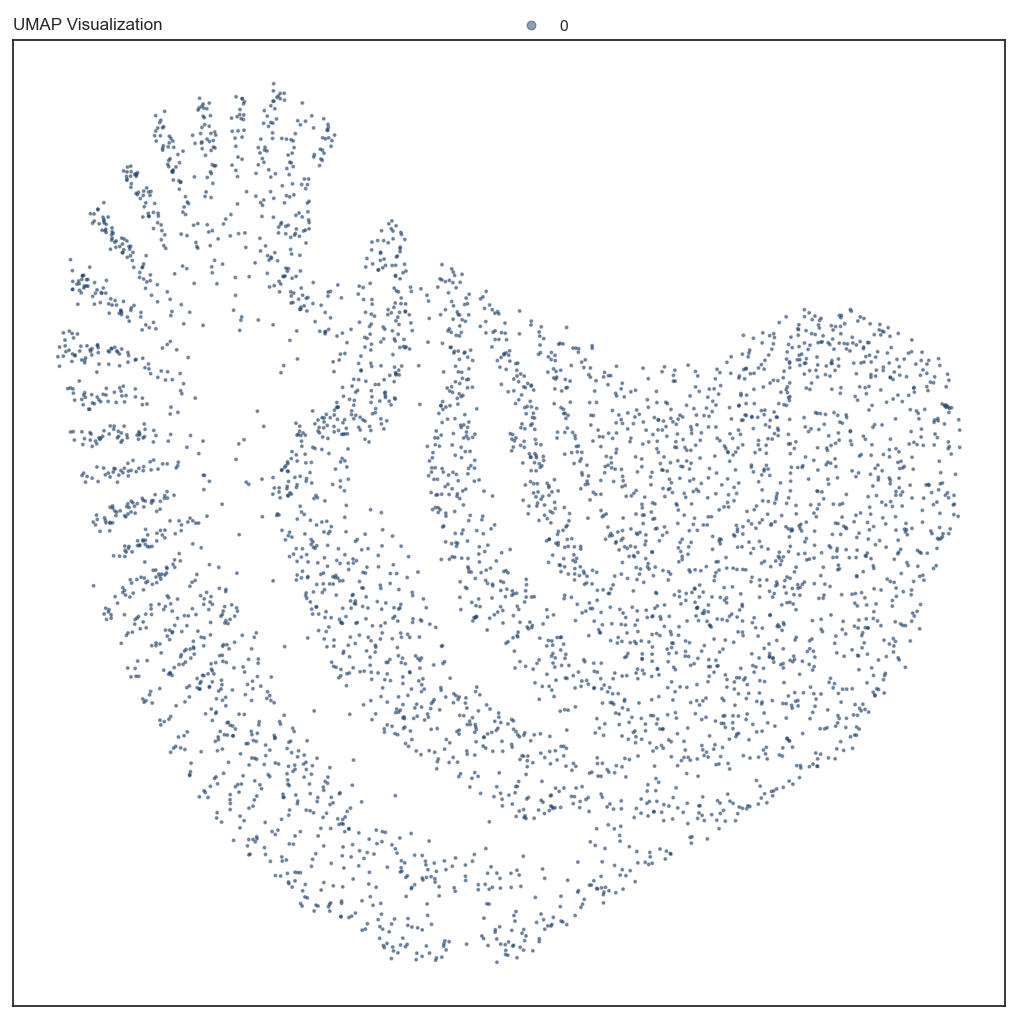

In [111]:
plot_labels(umap_data_df.iloc[:,0:2], umap_data_df['label'], 'UMAP Visualization')

In [112]:
customer_kmeans = KMeans(n_clusters=2, init='k-means++', 
                         max_iter=1000, random_state=RANDOM_STATE)

umap_data_df['label'] = customer_kmeans.fit_predict(df_cluster[df_cluster.columns])


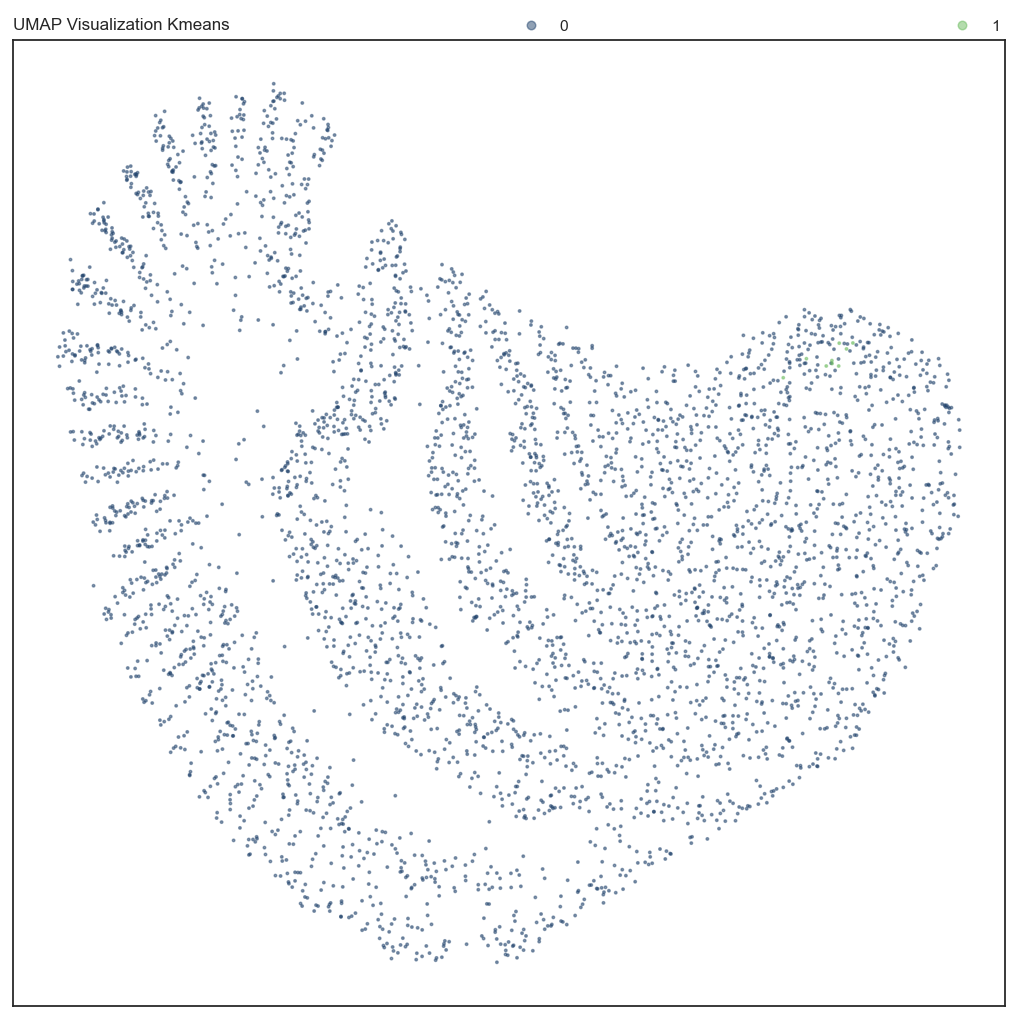

In [113]:
plot_labels(umap_data_df.iloc[:,0:2], umap_data_df['label'], 'UMAP Visualization Kmeans')